# Topopgraphy and rivers map of region (Tibet)

### Database

- [Earth2014](http://ddfe.curtin.edu.au/models/Earth2014/) (Arc‐min shape, topography, bedrock and ice‐sheet models)
- [GSHHG](http://www.soest.hawaii.edu/pwessel/gshhg/index.html) (Global Self-consistent, Hierarchical, High-resolution Geography Database)
- [WDBII](https://www.evl.uic.edu/pape/data/WDB/) (CIA World DataBank II)

Here downloads [Earth2014.TBI2014.5min.geod.bin](http://ddfe.curtin.edu.au/models/Earth2014/data_5min/topo_grids/) and 
 the GSHHG (data verison and format: 2.3.7 - shp) from [SOEST server](http://www.soest.hawaii.edu/pwessel/gshhg/index.html).

In [1]:
import numpy as np
import os
import pyshtools as pysh
import shapefile

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from matplotlib.colors import LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
dir_db   = '../data/earth2014/data_5min/topo_grids'
fname_db = 'Earth2014.TBI2014.5min.geod.bin' 
fname_save  = 'Earth2014.TBI2014.5min' 

fname_topo = os.path.join(dir_db,fname_db)

In [3]:
# This scirpt shows how to access the data grids of earth2014 model
# Source code: access_Earth2014_grids5min.m (Christian Hirt, Moritz Rexer)

# grid definitions
res_deg = 5/60 # 5min data
extent_global = [-180, 180, -90, 90]
minlon,maxlon,minlat,maxlat = extent_global
lats = np.arange((minlat+res_deg/2),(maxlat-res_deg/4),res_deg)
lons = np.arange((minlon+res_deg/2),(maxlon-res_deg/4),res_deg)
nlat = len(lats)
nlon = len(lons)
order_db = nlat
minlon1,maxlon1,minlat1,maxlat1 = (lons.min(),lons.max(),lats.min(),lats.max())
extent_earth2014 = [minlon1,maxlon1,minlat1,maxlat1]

# read data
data_topo = np.fromfile(fname_topo, dtype='>i2').reshape((nlat, nlon))
data_topo = data_topo.astype(np.int16) # data = data.astype('<i2')
data_topo = np.flipud(data_topo)

In [4]:
# get SHCs
topo = pysh.SHGrid.from_array(data_topo)
coeffs = pysh.expand.SHExpandDH(topo.data, sampling=2)

# Map

In [5]:
name_area ='Tibet'
extent_area = [65,110,15,45]
# TRR (88,108,20,36)

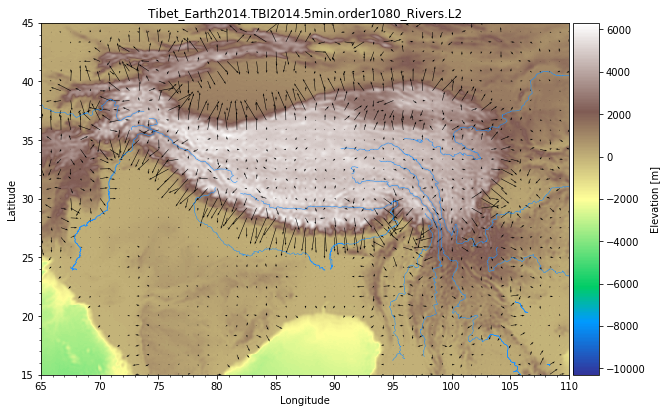

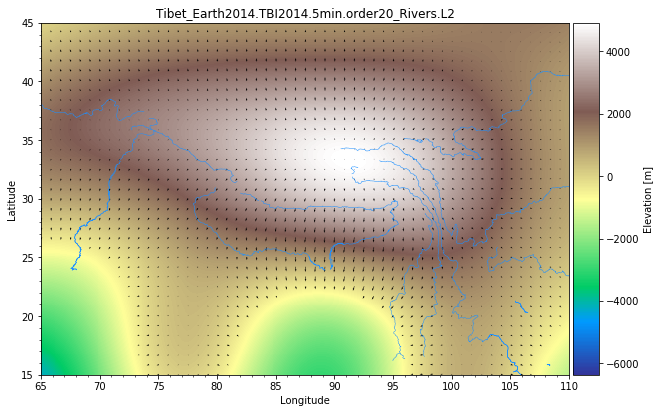

In [6]:
order_s = order_db 
order_tRange = [1080,20]
#order_trange = [2160,1080,540,270,135,27,20]

# river parameters
level = 2            # river database level 
resolution = "f"     # data sets resolution "fhilfc"
db_root_path = "../data/gshhg-shp-2.3.7" # input directory
db_name = 'WDBII'    # data name
tag = "river"         
format_string = "%s_%s_%s_L0%s.shp"

# plot parameters
extent_img = extent_earth2014  
extent_fig = extent_area
cmap = cm.terrain 
xticks = np.arange(-180,210,5)
yticks = np.arange(-90,120,5)
dpi    = 100
save_mode = True

arrow_width = 0.001
arrow_scale = 50000

for i in range(0,len(order_tRange)):
    # filter by processing SHCs
    order_t = order_tRange[i]
    lmax = int(order_t+1)
    coeffs_f = coeffs.copy()
    coeffs_f[:, lmax:, :] = 0.
    topo_f = pysh.expand.MakeGridDH(coeffs_f, sampling=2)
    
    # plot parameters
    data_img = topo_f.copy()
    order_img = order_t
    fname_fig = name_area + '_'+ fname_save + '.order'+ str(order_img) + '_Rivers.L' + str(level)
  
    # res_d = int(res/res_t)
    res_dy = 10 
    res_dx = 10 

    y = lats[::res_dy]
    x = lons[::res_dx] 
    X,Y = np.meshgrid(x,y)

    ZZ = np.flipud(data_img.copy())
    ZZ[ZZ<-500.0] = -500.0
    ZZ = ZZ[::res_dy,::res_dx]
    UY,UX= np.gradient(-ZZ)
    #UX = UX.reshape((X.shape[0],X.shape[1]))
    #UY = UY.reshape((X.shape[0],X.shape[1]))

    mask = ZZ > -500.0
    X_A=X[mask]
    Y_A=Y[mask]
    UX_A=UX[mask]
    UY_A=UY[mask]

    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    im = ax.imshow(data_img, extent=extent_img,cmap=cmap)
    ax.quiver(X_A,Y_A,UX_A,UY_A,width=arrow_width,scale=arrow_scale)
    #ax.streamplot(X, Y, UX, UY, color='k',density=1.0)
    #ax.contour(X,Y,ZZ)
    
    levels = range(1, level + 1)
    for i_level in levels:
        fname_shape = os.path.join(db_root_path, '%s_shp' % db_name,resolution, format_string % (db_name, tag, resolution, i_level))
        sf = shapefile.Reader(fname_shape)
        shapes = sf.shapes()
        for shape in shapes:
            for i_part in range(len(shape.parts)):
                i_start = shape.parts[i_part]
                if i_part==len(shape.parts)-1:
                    i_end = len(shape.points)
                else:
                    i_end = shape.shape.parts[i_part+1]
                x = [ii[0] for ii in shape.points[i_start:i_end]]
                y = [ii[1] for ii in shape.points[i_start:i_end]]
                ax.plot(x,y,'dodgerblue',linewidth=0.5)
    
    ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks, xticks=xticks)
    ax.minorticks_on()
    ax.set_title(fname_fig)
    ax.axis(extent_fig)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label('Elevation [m]')

    if save_mode == True:
        plt.savefig((fname_fig+'.png'),dpi=dpi)
    plt.show()

## Save data as geotiff file

In [11]:
from osgeo import gdal
from osgeo import osr

In [12]:
# data=(ny,nx) version
def array2geotiff_yx(fname, data, latRange, lonRange, dtype):   
    """
    save GeoTiff file from the array of dem data
    input:
        fname: save file name
        data: elevation data, an array in size of (n_lat,n_lon) 
        latRange: range of latitude, an array as [minlat,maxlat]
        lonRange: range of longitude, an array as [minlon,maxlon]
        dtype: dtype in gdal, as gdal.GDT_Byte or gdal.GDT_Float32
    """   
    nx = data.shape[1]
    ny = data.shape[0]
    xmin,xmax,ymin,ymax = [lonRange[0],lonRange[1],latRange[0],latRange[1]]
    dx = (xmax - xmin) / float(nx)
    dy = (ymax - ymin) / float(ny)
    geotransform = (xmin, dx, 0, ymax, 0, -dy)
    dst = gdal.GetDriverByName('GTiff').Create(fname, nx, ny, 1, dtype)
    dst.SetGeoTransform(geotransform) 
    dst.GetRasterBand(1).WriteArray(data)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    dst.SetProjection(srs.ExportToWkt())  
    dst.FlushCache() 

In [13]:
# grid definitions of region
minlon2,maxlon2,minlat2,maxlat2 = extent_area  

minX_index = np.int(nlon/(maxlon1-minlon1)*(minlon2-minlon1))
maxX_index = np.int(nlon/(maxlon1-minlon1)*(maxlon2-minlon1)) 
minY_index = np.int(nlat/(maxlat1-minlat1)*(minlat2-minlat1)) 
maxY_index = np.int(nlat/(maxlat1-minlat1)*(maxlat2-minlat1))

# real coordinates 
minlon3,maxlon3,minlat3,maxlat3 = (lons[minX_index],lons[maxX_index],lats[minY_index],lats[maxY_index])

In [14]:
topo_fs = np.flipud(topo_f)
data = topo_fs[minY_index:maxY_index,minX_index:maxX_index]
data = np.flipud(data)

fname_data = name_area + '_'+ fname_save + '.order'+ str(order_t)+ '.tif'
latRange = [minlat3,maxlat3]
lonRange = [minlon3,maxlon3]
dtype = gdal.GDT_Float32

array2geotiff_yx(fname_data, data, latRange, lonRange, dtype)